In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
#os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".25"

import torch
torch.multiprocessing.set_start_method('spawn')

In [4]:
# Add parent folder to path (to run this file from subdirectories)
(parent_folder_path, current_dir) = os.path.split(os.path.abspath(''))
sys.path.append(parent_folder_path)

# add git submodule to path to allow imports to work
submodule_name = 'AlphaTrade'
(parent_folder_path, current_dir) = os.path.split(os.path.abspath(''))
sys.path.append(os.path.join(parent_folder_path, submodule_name))

from gymnax_exchange.jaxob.jorderbook import OrderBook
import gymnax_exchange.jaxob.JaxOrderbook as job

In [5]:
from argparse import Namespace
from glob import glob
import numpy as onp
import pandas as pd
from functools import partial
from typing import Union, Optional
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax.nn import one_hot
from jax import random
from jax.scipy.linalg import block_diag
from flax import jax_utils
from flax.training import checkpoints
import orbax

#from lob.lob_seq_model import BatchLobPredModel
from lob.train_helpers import create_train_state, eval_step, prep_batch, cross_entropy_loss, compute_accuracy
from s5.ssm import init_S5SSM
from s5.ssm_init import make_DPLR_HiPPO
from s5.dataloading import make_data_loader
from lob_seq_model import LobPredModel
from encoding import Vocab, Message_Tokenizer
from lobster_dataloader import LOBSTER_Dataset, LOBSTER_Subset, LOBSTER_Sampler, LOBSTER

import preproc
import inference
import validation_helpers as valh
from lob.init_train import init_train_state, load_checkpoint, load_args_from_checkpoint

# necessary for flax checkpoints to be loaded in jupyter notebook
import nest_asyncio
nest_asyncio.apply()

In [101]:
from lob.dataloading import create_lobster_prediction_dataset


(lobster_dataset, trainloader, valloader, testloader, aux_dataloaders, 
n_classes, seq_len, in_dim, book_seq_len, book_dim, train_size) = \
create_lobster_prediction_dataset(
    '../data/new_enc/',
    seed=42,
    mask_fn=LOBSTER_Dataset.causal_mask,
    msg_seq_len=500,
    bsz=16,
    use_book_data=True,
    use_simple_book=False,
    book_transform=True,
    n_data_workers=0,
)

[*] Generating LOBSTER Prediction Dataset from ../data/new_enc/
Using mask function: <function LOBSTER_Dataset.causal_mask at 0x7fd5b015b0d0>


## Model

In [6]:
n_messages = 500
v = Vocab()
n_classes = len(v)
seq_len = n_messages * Message_Tokenizer.MSG_LEN
book_dim = 501 #b_enc.shape[1]
book_seq_len = n_messages

rng = jax.random.PRNGKey(42)
rng, rng_ = jax.random.split(rng)

In [7]:
# ckpt_path = '../checkpoints/brisk-surf-147_yc8wpyi3/'
# ckpt_path = '../checkpoints/scarlet-voice-168_iqq80fnp/'
# ckpt_path = '../checkpoints/ancient-dawn-506_ykmjf41l/'  # FLAIR Node trained on 0.5 years of GOOG
# ckpt_path = '../checkpoints/bumbling-sun-108_idstu91x/'  # new encoding
ckpt_path = '../checkpoints/rare-field-129_i52a4aga/'  # new encoding, 0.5 years of GOOG

In [8]:
args = load_args_from_checkpoint(ckpt_path)
args

Namespace(C_init='trunc_standard_normal', USE_WANDB=True, activation_fn='half_glu1', batchnorm=True, bidirectional=True, blocks=8, bn_momentum=0.95, book_depth=500, book_transform=True, bsz=32, clip_eigs=True, conj_sym=True, cosine_anneal=True, d_model=128, dataset='lobster-prediction', dir_name='./data', discretization='zoh', dt_global=False, dt_max=0.1, dt_min=0.001, early_stop_patience=1000, epochs=100, jax_seed=42, lr_factor=1.0, lr_min=0, lr_patience=1000000, masking='causal', mode='pool', msg_seq_len=500, n_book_post_layers=1, n_book_pre_layers=1, n_data_workers=0, n_layers=6, n_message_layers=2, num_devices=2, opt_config='BandCdecay', p_dropout=0.2, prenorm=True, reduce_factor=1.0, restore=None, restore_step=None, ssm_lr_base=0.0005, ssm_size_base=256, use_book_data=True, use_simple_book=False, wandb_entity='peer-nagy', wandb_project='LOBS5', warmup_end=1, weight_decay=0.05)

In [9]:
# scale down to single GPU, single sample inference
args.bsz = 1
args.num_devices = 1

batchnorm = args.batchnorm

In [10]:
# load train state from disk

new_train_state, model_cls = init_train_state(
    args,
    n_classes=n_classes,
    seq_len=seq_len,
    book_dim=book_dim,
    book_seq_len=book_seq_len,
)

ckpt = load_checkpoint(
    new_train_state,
    ckpt_path,
    args.__dict__)
par_state = ckpt['model']

configuring optimization with B in AdamW setup
[*] Trainable Parameters: 6334776


In [11]:
# deduplicate params (they get saved per gpu in training)
state = par_state.replace(
    params=jax.tree_map(lambda x: x[0], par_state.params),
    batch_stats=jax.tree_map(lambda x: x[0], par_state.batch_stats),
)

In [12]:
model = model_cls(training=False, step_rescale=1.0)

### Forecasting

In [13]:
import lob.evaluation as eval
from lob.preproc import transform_L2_state

In [14]:
n_gen_msgs = 100  #500 # how many messages to generate into the future
n_messages = 500
n_eval_messages = 100  # how many to load from dataset 
eval_seq_len = n_eval_messages * Message_Tokenizer.MSG_LEN

data_levels = 10
sim_book_levels = 20 # 10  # order book simulator levels
sim_queue_len = 100  # per price in sim, how many orders in queue

In [15]:
dataset_obj = LOBSTER(
    'lobster',
    data_dir='/nfs/home/peern/LOBS5/data/new_enc/',
    # use dummy mask function to get entire sequence
    mask_fn=lambda X, rng: (X, jnp.array(0)),
    use_book_data=True,
    # book_transform=True,  # transform book to image
    use_simple_book=True,  # return (p,v) book and we'll do transorm to volume image later
    msg_seq_len=n_messages + n_eval_messages,
    return_raw_msgs=True,
    raw_data_dir='/nfs/home/peern/LOBS5/data/raw/',
    n_cache_files=100,  # keep high enough to fit all files in memory
)
dataset_obj.setup()

ds = dataset_obj.dataset_test

In [16]:
from line_profiler import LineProfiler

In [17]:
import chex
chex.clear_trace_counter()

In [20]:
import logging
# logging.basicConfig(filename='ar_debug.log', level=logging.DEBUG)
fhandler = logging.FileHandler(filename='ar_debug.log', mode='w')
logger = logging.getLogger()
if (logger.hasHandlers()):
    logger.handlers.clear()
logger.addHandler(fhandler)
logger.setLevel(logging.DEBUG)
#logger.setLevel(logging.WARNING)

In [92]:
#%%prun -s cumulative
# profile function calls (not line by line)

rng = jax.random.PRNGKey(1)  #
rng, rng_ = jax.random.split(rng)

lp = LineProfiler()
lp.add_function(inference.get_sim_msg)   # add additional function to profile
inference_generate_lp = lp(inference.generate)

rets_gen = []
rets_eval = []
# squared errors of n-step forward return predictions
mid_ret_errs = []
# squared errors of returns using constant mid-price prediction
mid_ret_errs_const = []
# mean abs losses of book levels
book_losses_l1 = []
# benchmark: mean abs losses of book levels (constant prediction)
book_losses_l1_const = []
# wasserstein distance of book levels
book_losses_wass = []
book_losses_wass_const = []
# how many messages had to be discarded
num_errors = []
event_types_gen = []
event_types_eval = []
# inter-arrival times
delta_t_gen = []
delta_t_eval = []

# draw n random samples from dataset for evaluation
n_samples = 1 # 500
sample_i = jax.random.choice(
    rng_,
    jnp.arange(len(ds), dtype=jnp.int32),
    shape=(n_samples,),
    replace=False)

# iteratre over all test data
#for i in tqdm(range(len(ds))):
# iterate over random samples
for i in tqdm(sample_i):
    print(f'Processing sample {i}...')

    # 0: encoded message sequence
    # 1: prediction targets (dummy 0 here)
    # 2: book sequence (in Price, Volume format)
    # 3: raw message sequence (pandas df from LOBSTER)
    # 4: initial level 2 book state (before start of sequence)
    m_seq, _, b_seq_pv, msg_seq_raw, book_l2_init = ds[int(i)]

    # transform book to volume image representation for model
    b_seq = jnp.array(transform_L2_state(b_seq_pv, dataset_obj.book_depth, 100))

    # encoded data
    m_seq_inp = m_seq[: seq_len]
    m_seq_eval = m_seq[seq_len: ]
    b_seq_inp = b_seq[: n_messages]
    b_seq_eval = b_seq[n_messages: ]
    # true L2 data
    b_seq_pv_eval = jnp.array(b_seq_pv[n_messages: ])

    # raw LOBSTER data
    m_seq_raw_inp = msg_seq_raw.iloc[: n_messages]
    m_seq_raw_eval = msg_seq_raw.iloc[n_messages: ]

    # initialise simulator
    sim_init, _trades = inference.get_sim(
        book_l2_init,
        m_seq_raw_inp,
        sim_book_levels=sim_book_levels,
        sim_queue_len=sim_queue_len,
    )
    l2_book_state_init = job.get_l2_state(sim_init.orderbook_array)

    # run actual messages on sim_eval (once) to compare
    sim_eval = inference.copy_orderbook(sim_init)
    # convert m_seq_raw_eval to sim_msgs
    msgs_eval = inference.msgs_to_jnp(m_seq_raw_eval.iloc[: n_eval_messages])
    l2_book_states_eval, _ = sim_eval.process_orders_array_l2(msgs_eval)

    l2_book_states = []

    # TODO: repeat for multiple scenarios from same input to average over
    #       --> parallelise? loaded data is the same, just different rngs
    J = 1
    for j_rep in range(J):
        print('ITERATION', j_rep)

        # TODO: split random seed rng
        rng, rng_ = jax.random.split(rng)
    
        # copy initial order book state for generation
        sim = inference.copy_orderbook(sim_init)

        # generate predictions
        #m_seq_gen, b_seq_gen, m_seq_raw_gen, l2_book_states = inference.generate(
        m_seq_gen, b_seq_gen, m_seq_raw_gen, l2_book_states_j, err = inference.generate(  # inference_generate_lp(
            m_seq_inp,
            b_seq_inp,
            m_seq_raw_inp,
            n_gen_msgs,
            sim,
            state,
            model,
            batchnorm,
            rng_,
        )
        # only keep actually generated messages
        m_seq_raw_gen = m_seq_raw_gen.iloc[-n_gen_msgs:]

        event_types_gen.append(
            eval.event_type_count(jnp.array(m_seq_raw_gen.values[:, 1])))
        event_types_eval.append(
            eval.event_type_count(jnp.array(m_seq_raw_eval.values[:, 1])))

        num_errors.append(err)

        l2_book_states.append(l2_book_states_j)

    # arrival times
    x = m_seq_raw_gen.time.diff().dropna()
    x = x.replace({0.: x[x>0].min()}).values
    delta_t_gen.append(x)
    x = m_seq_raw_eval.time.diff().dropna()
    x = x.replace({0.: x[x>0].min()}).values
    delta_t_eval.append(x)
    
    # (J x S x features) book states
    l2_book_states = jnp.array(l2_book_states)

    ## MID PRICE EVAL:
    # mid price at start of generation
    mid_t0 = b_seq_pv[n_messages - 1, [1, 3]].mean()

    # mean mid-price over J iterations
    mid_gen = jnp.mean(
        (l2_book_states[:, :, 0] + l2_book_states[:, :, 2]) / 2.,
        axis=0
    )
    mid_ret_gen = mid_gen / mid_t0 - 1
    rets_gen.append(mid_ret_gen)
    mid_eval = (l2_book_states_eval[:, 0] + l2_book_states_eval[:, 2]) / 2.
    mid_ret_eval = mid_eval / mid_t0 - 1
    rets_eval.append(mid_ret_eval)
    
    # shape: (n_eval_messages, )
    mid_ret_squ_err = eval.mid_price_ret_squ_err(
        mid_gen, mid_eval, mid_t0)
    mid_ret_errs.append(mid_ret_squ_err)
    # compare to squared error from const prediction
    
    mid_ret_errs_const.append(
        jnp.square(mid_ret_eval)
    )
    
    ## BOOK EVAL:
    # get loss sequence using J generations and 1 evaluation
    book_loss_l1_j = eval.book_loss_l1_batch(l2_book_states, l2_book_states_eval, data_levels)
    book_losses_l1.append(book_loss_l1_j)
    book_loss_wass_j = eval.book_loss_wass_batch(l2_book_states, l2_book_states_eval, data_levels)
    book_losses_wass.append(book_loss_wass_j)
    # compare to loss between fixed book (at t0) and actual book
    # --> as if we were predicting with the most recent observation
    book_loss_l1_const = eval.book_loss_l1(
        jnp.tile(l2_book_state_init, (l2_book_states_eval.shape[0], 1)),
        l2_book_states_eval,
        data_levels
    )
    book_losses_l1_const.append(book_loss_l1_const)
    book_loss_wass_const = eval.book_loss_wass(
        jnp.tile(l2_book_state_init, (l2_book_states_eval.shape[0], 1)),
        l2_book_states_eval,
        data_levels
    )
    book_losses_wass_const.append(book_loss_wass_const)

rets_gen = jnp.array(rets_gen)
rets_eval = jnp.array(rets_eval)
book_losses_l1 = jnp.array(book_losses_l1)
book_losses_l1_const = jnp.array(book_losses_l1_const)
book_losses_wass = jnp.array(book_losses_wass)
book_losses_wass_const = jnp.array(book_losses_wass_const)
mid_ret_errs = jnp.array(mid_ret_errs)
mid_ret_errs_const = jnp.array(mid_ret_errs_const)
num_errors = jnp.array(num_errors)
event_types_gen = jnp.array(event_types_gen)
event_types_eval = jnp.array(event_types_eval)

# use ONP for float64 precision
delta_t_gen = onp.array(delta_t_gen)
delta_t_eval = onp.array(delta_t_eval)

lp.print_stats()


  0%|          | 0/1 [00:00<?, ?it/s]

Processing sample 2970...
ITERATION 0
Timer unit: 1e-09 s

Total time: 0 s
File: /nfs/home/peern/LOBS5/lob/inference.py
Function: get_sim_msg at line 107

Line #      Hits         Time  Per Hit   % Time  Line Contents
   107                                           def get_sim_msg(
   108                                                   pred_msg_enc: onp.ndarray,
   109                                                   m_seq: onp.ndarray,
   110                                                   m_seq_raw: pd.DataFrame,
   111                                                   sim: OrderBook,
   112                                                   tok: Message_Tokenizer,
   113                                                   v: Vocab,
   114                                                   new_order_id: int,
   115                                                   tick_size: int
   116                                               ) -> Tuple[Optional[Dict[str, Any]], Optional[onp.n

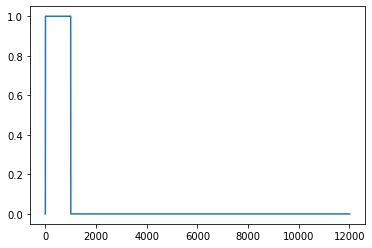

In [93]:
valid_mask_array = valh.syntax_validation_matrix(v)
plt.plot(valid_mask_array[i_s: i_e][2] * 1)

[ 844   38   30    4    6   21   21    4   25   24    3   57   34   76
   46  992  995  695  205  985  648   90  701  691   31   15    4   23
    5   11    4   22  215   38   17   32   17    3    3    3    4   29
   43  289  105  171  945  679  123  995   55  455  566   16   92  206
   26   17   24    3   57   63   30   33  951  543   72  336  857  127
  786  133  330   96    3  126    3  572  163   44  319  682  189  784
  194  294  171  274  446  864  121  742  514    3   91  602    3  288
 1002   78]


(array([53., 11.,  7.,  3.,  2.,  5.,  6.,  3.,  3.,  7.]),
 array([   3. ,  102.9,  202.8,  302.7,  402.6,  502.5,  602.4,  702.3,
         802.2,  902.1, 1002. ]),
 <BarContainer object of 10 artists>)

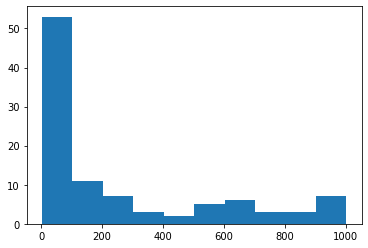

In [99]:
i_s, i_e = valh.get_idx_from_field('delta_t')
delta_t_toks_eval = m_seq_eval.reshape(-1, Message_Tokenizer.MSG_LEN)[:, i_s:i_e]
#for r in delta_t_toks_eval:
#    print(r)

print(delta_t_toks_eval[:, 2])
plt.hist(delta_t_toks_eval[:, 2])

[ 4 21 38 17 14 25 10 25 42 29 37  8 33 15 23  3 17 28 33 22  3  3  3 11
 48 15 21 30 23  9  3  3  3  3 12  8  3  3 36 19 38  8  3 18  3  3  3  3
  3  6 30 14 15 24  3 18  3  3  8 13 22 48  3 11 44 36  3  3  3 28  6  7
 10 36 11 21 12  5  4  3  4 41 18 36 26  7  3  8 14  8 10 19 32  8  3 17
 14 16 10 15]


(array([34., 15., 12.,  8., 10.,  4.,  5.,  7.,  2.,  3.]),
 array([ 3. ,  7.5, 12. , 16.5, 21. , 25.5, 30. , 34.5, 39. , 43.5, 48. ]),
 <BarContainer object of 10 artists>)

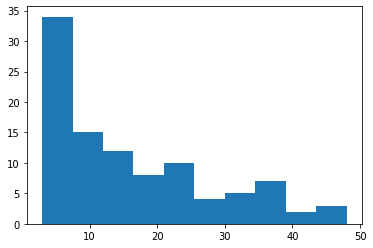

In [100]:
i_s, i_e = valh.get_idx_from_field('delta_t')
delta_t_toks_gen = m_seq_gen.reshape(-1, Message_Tokenizer.MSG_LEN)[-n_gen_msgs: , i_s:i_e]
# for r in delta_t_toks_gen:
#     print(r)

print(delta_t_toks_gen[:, 2])
plt.hist(delta_t_toks_gen[:, 2])

In [45]:
Message_Tokenizer.FIELD_I

{'event_type': 0,
 'direction': 1,
 'price': 2,
 'size': 3,
 'delta_t': 4,
 'time': 5,
 'price_ref': 6,
 'size_ref': 7,
 'time_ref': 8}

(9, 14)

In [22]:
import pickle
import datetime

results = {
    'rets_gen': rets_gen,
    'rets_eval': rets_eval,
    'book_losses_l1': book_losses_l1,
    'book_losses_l1_const': book_losses_l1_const,
    'book_losses_wass': book_losses_wass,
    'book_losses_wass_const': book_losses_wass_const,
    'mid_ret_errs': mid_ret_errs,
    'mid_ret_errs_const': mid_ret_errs_const,
    'num_errors': num_errors,
    'event_types_gen': event_types_gen,
    'event_types_eval': event_types_eval,
    'delta_t_gen': delta_t_gen,
    'delta_t_eval': delta_t_eval,
}
# format current timestamp
ts = datetime.datetime.now().strftime('%Y.%m.%d_%H:%M:%S')
# save results dict as pickle file
with open(f'./{ts}_inference_results_dict.pkl', 'wb') as f:
    pickle.dump(results, f)

In [28]:
with open(f'./inference_results_dict.pkl', 'rb') as f:
    results = pickle.load(f)

In [38]:
t_ = m_seq_raw_eval.time.diff()
t_.loc[t_ < 0.0000001]

532    0.0
544    0.0
Name: time, dtype: float64

In [33]:
results['delta_t_eval'].min()

1.4199758879840374e-07

In [ ]:
l2_book_states.shape

(1, 100, 80)

In [23]:
# check for uniqueness of book states (successive ones should be)
unq, count = jnp.unique(l2_book_states[0], axis=0, return_counts=True)
jnp.argwhere(count > 1)

Array([[14],
       [21],
       [30],
       [35],
       [37],
       [57],
       [72],
       [73],
       [74],
       [75],
       [77],
       [83]], dtype=int32)

Text(0.5, 1.0, 'Event Type Distribution')

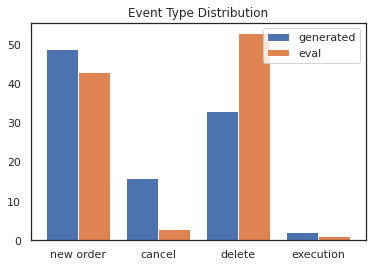

In [140]:
width = 0.4
x = onp.array(range(1,5))
plt.bar(x-0.2, event_types_gen, width=width, label='generated')
plt.bar(x+0.2, event_types_eval, width=width, label='eval')
plt.legend()
plt.xticks(x, ('new order', 'cancel', 'delete', 'execution'))
plt.title('Event Type Distribution')

Text(0.5, 1.0, 'Event Type Distribution')

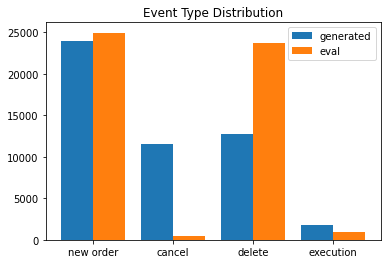

In [24]:
# plot frequency of order types over all runs (all samples and repeats)

width = 0.4
x = onp.array(range(1,5))
plt.bar(x-0.2, event_types_gen.sum(axis=0), width=width, label='generated')
plt.bar(x+0.2, event_types_eval.sum(axis=0), width=width, label='eval')
plt.legend()
plt.xticks(x, ('new order', 'cancel', 'delete', 'execution'))
plt.title('Event Type Distribution')

In [57]:
# CAVE: float64 would be needed to represent this accurately in jax as well
jnp.diff(jnp.array(m_seq_raw_gen.values[:, 0], dtype=jnp.float64))

/tmp/ipykernel_1196138/540897997.py:2: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  jnp.diff(jnp.array(m_seq_raw_gen.values[:, 0], dtype=jnp.float64))


Array([0.        , 0.        , 0.        , 0.0078125 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00390625, 0.        , 0.0078125 , 0.        ,
       0.00390625, 0.00390625, 0.        , 0.        , 0.        ,
       0.        , 0.0078125 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00390625, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00390625, 0.        , 0.015625  , 0.        , 0.        ,
       0.        , 0.        , 0.0078125 , 0.        , 0.        ,
       0.        , 0.        , 0.00390625, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

Text(0.5, 1.0, 'Inter-Arrival Time Distribution')

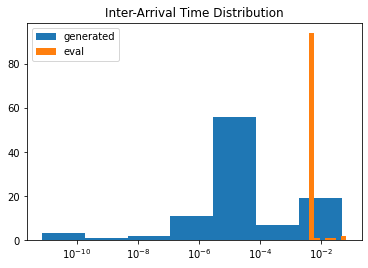

In [56]:
def plot_log_hist(x, label=None):
    hist, bins = onp.histogram(x)
    logbins = onp.geomspace(x.min(), x.max(), 8)
    plt.hist(x, bins=logbins, label=label)
    plt.xscale('log')
    plt.legend()

x = m_seq_raw_gen.time.diff().dropna()
x = x.replace({0.: x[x>0].min()}).values
plot_log_hist(x, label='generated')

x = m_seq_raw_eval.time.diff().dropna()
x = x.replace({0.: x[x>0].min()}).values
plot_log_hist(x, label='eval')

plt.title('Inter-Arrival Time Distribution')


[3.00497049e-09 3.15233269e-08 3.30692144e-07 3.46909115e-06
 3.63921358e-05 3.81767872e-04 4.00489570e-03 4.20129370e-02]
[2.21996743e-07 1.67625659e-06 1.26571054e-05 9.55714758e-05
 7.21642644e-04 5.44899094e-03 4.11443288e-02 3.10673263e-01]


Text(0.5, 1.0, 'Inter-Arrival Time Distribution')

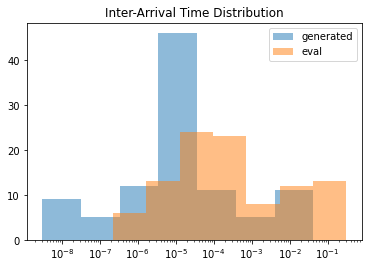

In [118]:
def plot_log_hist(x, label=None):
    hist, bins = onp.histogram(x)
    logbins = onp.geomspace(x.min(), x.max(), 8)
    print(logbins)
    plt.hist(x, bins=logbins, label=label, alpha=0.5)
    plt.xscale('log')
    plt.legend()

x = m_seq_raw_gen.time.diff().dropna()
x = x.replace({0.: x[x>0].min()}).values
plot_log_hist(x, label='generated')

x = m_seq_raw_eval.time.diff().dropna()
x = x.replace({0.: x[x>0].min()}).values
plot_log_hist(x, label='eval')

plt.title('Inter-Arrival Time Distribution')


In [62]:
# check dtype issues here
delta_t_gen.min()

-7.275957614183426e-12

[-7.27595761e-12             nan             nan             nan
             nan             nan             nan  6.00000285e+01]


/nfs/home/peern/miniconda3/envs/lob/lib/python3.8/site-packages/numpy/core/function_base.py:423: RuntimeWarning: invalid value encountered in log10
  log_start = _nx.log10(start)


Text(0.5, 1.0, 'Inter-Arrival Time Distribution')

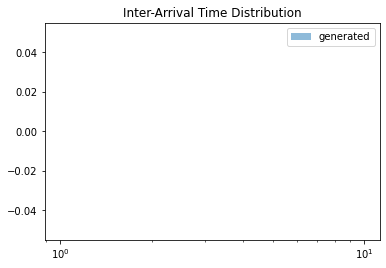

In [58]:
plot_log_hist(delta_t_gen[~onp.isnan(delta_t_gen)].flatten(), label='generated')
plot_log_hist(delta_t_eval.flatten(), label='eval')
plt.title('Inter-Arrival Time Distribution')

In [ ]:
# TODO: 
#       turn loop body into function returning dict of metrics
#       make sure no data leakage from train to test in training
#       inspect correlation data --> why so strong? especially for near future?

In [32]:
jnp.array(num_errors).reshape(-1, 3)

Array([[42, 16, 19],
       [ 4,  4, 12],
       [24, 27, 30],
       [17, 21, 20],
       [14, 22, 17],
       [22, 17, 33],
       [28, 12, 30],
       [18, 32, 28],
       [27,  9, 24],
       [11, 20, 22]], dtype=int32)

In [27]:
jnp.array(num_errors)#.reshape(-1, 4)

Array([ 21,  10,  24,  14,   7,  12,  18,  37,  15,  12,  14,  15,   6,
        18,  19,  57,  24,  16,   9,  17,  10,  18,  11,  17,  57,  12,
        14,  44,  13,  20,  18,  17,  13, 102,  12,  29,  22,  16,  27,
        11,  14,   8,  21,  16,  25,   6,  18,  16,  15,  31,  12,  10,
        13,  14,  51,  11,   9,  25,  23,  22,  18,  13,  16,  11,  23,
        16,  15,  11,  19,  18,  17,  11,   8,  20,  17,  23,  18,  27,
        13,  39,   6,  15,  11,  21,  18,  39,  25,  20,  19,  19,  16,
        25,  29,  27,  16,  20,  16,  13,  16,  17,   5,  17,  13,   8,
        10,  13,  12,  19,  27,   9,   6,  24,  14,  11,  16,  17,  17,
        19,   9,  15,  10,  15,  27,   6,  23,  14,  15,  11,  59,  12,
        21,   9,  15,  26,  37,  27,  19,  10,   9,  27,  38,  12,  33,
        19,  26,  50,  16,  33,  22,  19,  10,  72,  29,  62,   8,  16,
        26,  18,  19,  13,  12,  26,  17,   8,  20,  24,  22,  17,  14,
        22,  27,  25,  14,   9,  49,   6,  20,   7,   9,  14,  3

### Inference evaluation

Text(0, 0.5, 'Wasserstein distance')

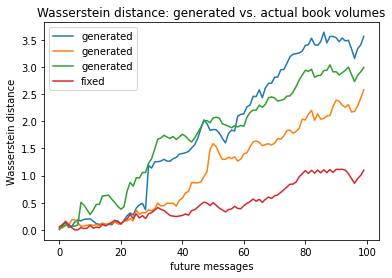

In [46]:
# single data sample

plt.plot(
    onp.arange(book_loss_wass_j.shape[1]),
    book_loss_wass_j.T,
    label='generated'
)
plt.plot(
    book_loss_wass_const,
    label='fixed'
)
plt.legend()
plt.title('Wasserstein distance: generated vs. actual book volumes')
plt.xlabel('future messages')
plt.ylabel('Wasserstein distance')

In [ ]:
%load_ext line_profiler

In [ ]:
# TODO: 
#       evaluate generated raw messages --> distribution matching etc.

In [33]:
rets_gen.shape

(10, 100)

In [34]:
rets_eval.shape

(10, 100)

In [ ]:
# note: mistake of comparing MEAN generated returns to realised returns

In [104]:
r_gen_mean = jnp.mean(rets_gen, axis=0)
r_gen_var = jnp.var(rets_gen, axis=0)
r_gen_skew = jnp.mean(jnp.power(rets_gen, 3), axis=0) / jnp.power(r_gen_var, 3/2)
r_gen_kurt = jnp.mean(jnp.power(rets_gen, 4), axis=0) / jnp.power(r_gen_var, 2) - 3

mean = jnp.mean(rets_gen)
r_eval_std = jnp.std(rets_eval)
rets_eval_no_outl = rets_eval.copy()
rets_eval_no_outl = rets_eval_no_outl.at[rets_eval_no_outl < -0.1].set(0)

r_eval_mean = jnp.mean(rets_eval_no_outl, axis=0)
r_eval_var = jnp.var(rets_eval_no_outl, axis=0)
r_eval_skew = jnp.mean(jnp.power(rets_eval_no_outl, 3), axis=0) / jnp.power(r_eval_var, 3/2)
r_eval_kurt = jnp.mean(jnp.power(rets_eval_no_outl, 4), axis=0) / jnp.power(r_eval_var, 2) - 3

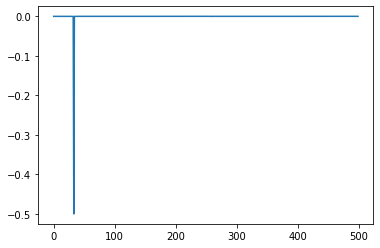

In [79]:
# TODO: inspect outliers in eval (!) returns
plt.plot(rets_eval[:, 29])

In [103]:
rets_eval.min()

Array(-0.49984777, dtype=float32)

In [101]:
r_eval_mean[29]

Array(-0.00100052, dtype=float32)

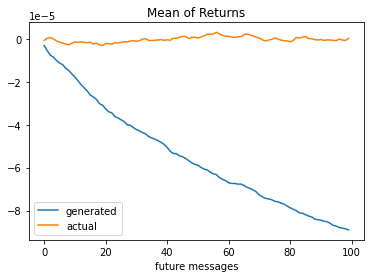

In [105]:
plt.plot(r_gen_mean, label='generated')
plt.plot(r_eval_mean, label='actual')
plt.title('Mean of Returns')
plt.xlabel('future messages')
plt.legend()

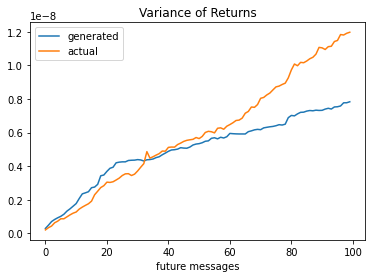

In [106]:
plt.plot(r_gen_var, label='generated')
plt.plot(r_eval_var, label='actual')
plt.title('Variance of Returns')
plt.xlabel('future messages')
plt.legend()

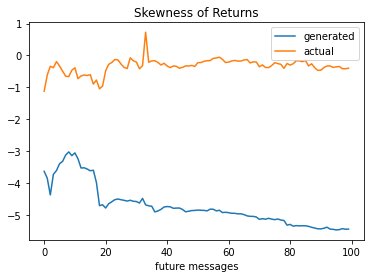

In [107]:
plt.plot(r_gen_skew, label='generated')
plt.plot(r_eval_skew, label='actual')
plt.title('Skewness of Returns')
plt.xlabel('future messages')
plt.legend()

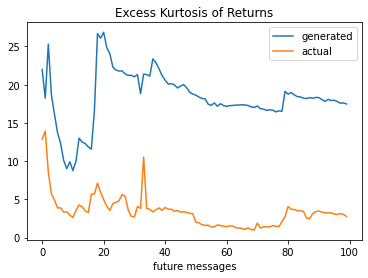

In [108]:
plt.plot(r_gen_kurt, label='generated')
plt.plot(r_eval_kurt, label='actual')
plt.title('Excess Kurtosis of Returns')
plt.xlabel('future messages')
plt.legend()

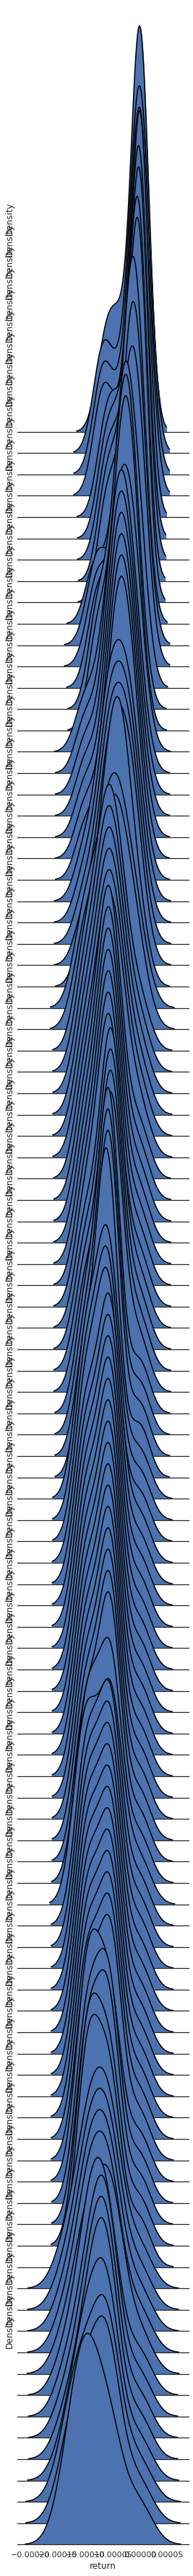

In [62]:
import seaborn as sns

rets_gen_df = pd.DataFrame(rets_gen).melt()
rets_gen_df.columns = ['time', 'return']
rets_gen_df

sns.set_theme(style="white")#), rc={"axes.facecolor": (0, 0, 0, 0)})
g = sns.FacetGrid(rets_gen_df, row="time", aspect=9, height=0.5)
g.map_dataframe(sns.kdeplot, x="return", fill=True, alpha=1)
g.map_dataframe(sns.kdeplot, x="return", color='black')
g.fig.subplots_adjust(hspace=-.95)
g.set_titles("")
g.set(yticks=[])
g.despine(left=True)

In [97]:
# why corr so high?
rets_gen[:, 6]

Array([ 0.0000000e+00,  5.0187111e-05, -5.0783157e-05,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00, -5.0604343e-05,  0.0000000e+00,
        1.1920929e-07, -1.0043383e-04,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00, -1.0031462e-04,  0.0000000e+00, -5.0723553e-05,
       -5.0663948e-05, -5.9604645e-08, -5.0485134e-05, -5.9604645e-08,
       -5.9604645e-08,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00], dtype=float32)

In [79]:
ret_corr = eval.return_corr(rets_gen, rets_eval)

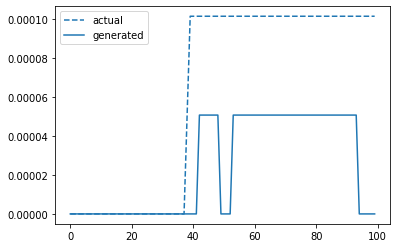

In [89]:
# TODO: plot this for multiple samples

_ = plt.plot(rets_eval.T, linestyle='--', label='actual')
# reset color cycle
plt.gca().set_prop_cycle(None)
_ = plt.plot(rets_gen.T, label='generated')
plt.legend()

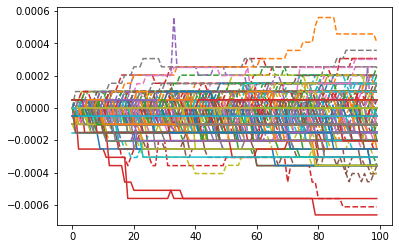

In [111]:
# TODO: plot this for multiple samples

_ = plt.plot(rets_eval_no_outl.T, linestyle='--', label='actual')
# reset color cycle
plt.gca().set_prop_cycle(None)
_ = plt.plot(rets_gen.T, label='generated')
#plt.legend()

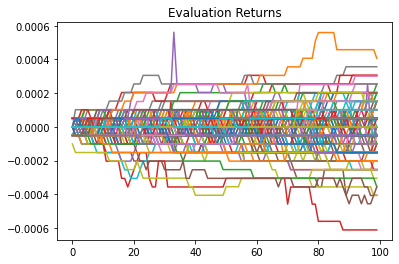

In [117]:
plt.title('Evaluation Returns')
_ = plt.plot(rets_eval_no_outl.T)

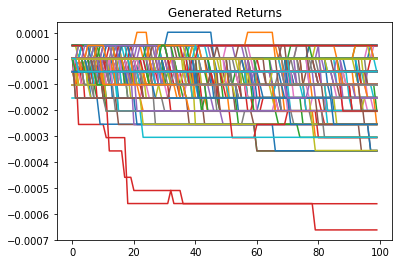

In [116]:
plt.title('Generated Returns')
_ = plt.plot(rets_gen.T)

Text(0, 0.5, 'Correlation Coefficient')

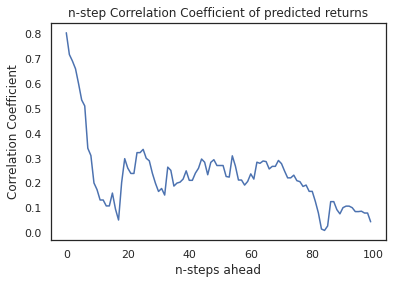

In [93]:
ret_corr = eval.return_corr(rets_gen, rets_eval)
plt.plot(ret_corr)
plt.title('n-step Correlation Coefficient of predicted returns')
plt.xlabel('n-steps ahead')
plt.ylabel('Correlation Coefficient')

Text(0, 0.5, 'Correlation Coefficient')

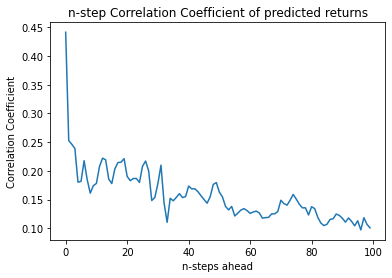

In [115]:
ret_corr = eval.return_corr(rets_gen, rets_eval_no_outl)
plt.plot(ret_corr)
plt.title('n-step Correlation Coefficient of predicted returns')
plt.xlabel('n-steps ahead')
plt.ylabel('Correlation Coefficient')

In [37]:
ret_corr

Array([0.44143698, 0.2526042 , 0.24634014, 0.23894048, 0.18034065,
       0.18181023, 0.21767107, 0.18477556, 0.16120993, 0.17416434,
       0.17819089, 0.20740923, 0.2221642 , 0.21931747, 0.18584883,
       0.1778848 , 0.20355316, 0.2145134 , 0.21513453, 0.22122993,
       0.19039235, 0.18293376, 0.18667023, 0.18680376, 0.17978667,
       0.20809738, 0.21713278, 0.19982076, 0.35285738, 0.35186568,
       0.1778724 , 0.20990409, 0.14446038, 0.11042722, 0.15226477,
       0.14792556, 0.1539265 , 0.16031003, 0.153475  , 0.15519568,
       0.1735889 , 0.16871533, 0.16882102, 0.16386242, 0.15679537,
       0.1501594 , 0.14366706, 0.15489396, 0.17634292, 0.17962365,
       0.16275974, 0.15459669, 0.13808075, 0.13205257, 0.138096  ,
       0.12144426, 0.12643386, 0.13173863, 0.13427526, 0.13082986,
       0.12598847, 0.1284139 , 0.12994857, 0.12658525, 0.11770965,
       0.11860835, 0.11902186, 0.12509687, 0.12514956, 0.1292944 ,
       0.14890815, 0.14298293, 0.14031903, 0.14877534, 0.15896

In [ ]:
#mid_price_loss_l1(l2_book_states, l2_book_states_eval)

Array([0. , 0. , 0. , 0. , 1. , 1. , 1.5, 1.5, 2.5, 2.5, 2.5, 3. , 3.5,
       3.5, 3.5, 3.5, 4. , 4. , 4. , 4. , 4. , 4.5, 4.5, 4.5, 5. , 5. ,
       5. , 4.5, 4. , 4. , 4. , 4. , 4. , 4. , 4. , 4. , 4. , 4. , 4. ,
       4. , 4. , 4. , 4. , 4. , 4.5, 5.5, 5.5, 5.5, 5.5, 5.5, 5.5, 5.5,
       5.5, 5.5, 5.5, 4. , 4. , 4. , 4. , 4. , 4. , 4. , 4. , 4. , 4. ,
       4. , 4. , 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 5. ,
       5. , 5. , 5. , 5. , 5. , 5. , 5. , 5. , 5. , 5. , 5. , 5. , 6. ,
       6. , 6. , 6. , 5.5, 5.5, 5.5, 5.5, 5.5, 5.5],      dtype=float32, weak_type=True)

Text(0, 0.5, 'mean abs. loss')

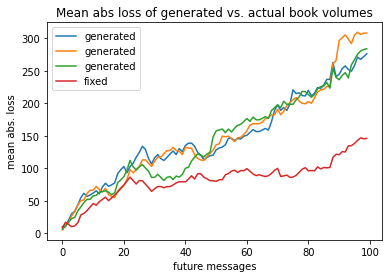

In [24]:
# single data sample

plt.plot(
    onp.arange(book_loss_l1_j.shape[1]),
    book_loss_l1_j.T,
    label='generated'
)
plt.plot(
    book_losses_l1_const.mean(axis=0),
    label='fixed'
)
plt.legend()
plt.title('Mean abs loss of generated vs. actual book volumes')
plt.xlabel('future messages')
plt.ylabel('mean abs. loss')

Text(0, 0.5, 'mean abs. loss')

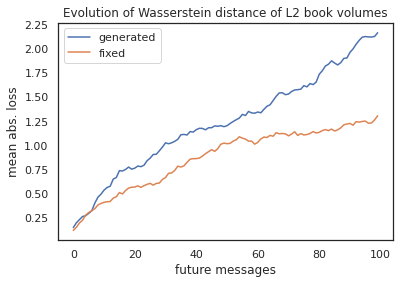

In [104]:
plt.plot(
    book_losses_wass.mean(axis=(0,1)),
    label='generated'
)
plt.plot(
    book_losses_wass_const.mean(axis=0),
    label='fixed'
)
plt.legend()
plt.title('Evolution of Wasserstein distance of L2 book volumes')
plt.xlabel('future messages')
plt.ylabel('mean abs. loss')

Text(0, 0.5, 'mean abs. loss')

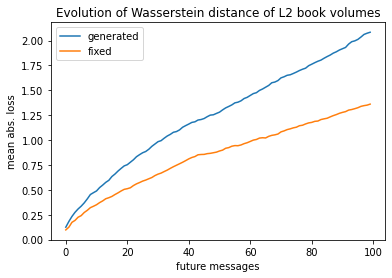

In [38]:
plt.plot(
    book_losses_wass.mean(axis=(0,1)),
    label='generated'
)
plt.plot(
    book_losses_wass_const.mean(axis=0),
    label='fixed'
)
plt.legend()
plt.title('Evolution of Wasserstein distance of L2 book volumes')
plt.xlabel('future messages')
plt.ylabel('mean abs. loss')

Text(0, 0.5, 'mean abs. loss')

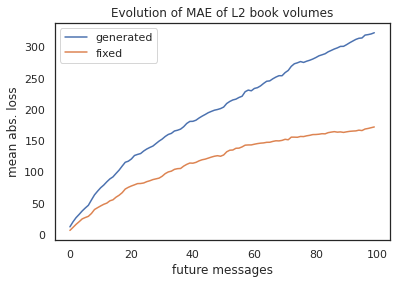

In [105]:
plt.plot(
    book_losses_l1.mean(axis=(0,1)),
    label='generated'
)
plt.plot(
    book_losses_l1_const.mean(axis=0),
    label='fixed'
)
plt.legend()
plt.title('Evolution of MAE of L2 book volumes')
plt.xlabel('future messages')
plt.ylabel('mean abs. loss')

Text(0, 0.5, 'Squared Error')

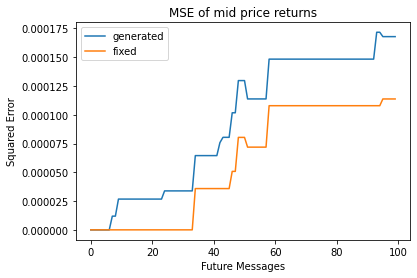

In [26]:
plt.plot(
    jnp.sqrt(mid_ret_errs.mean(axis=0)),
    label='generated'
)
plt.plot(
    jnp.sqrt(mid_ret_errs_const.mean(axis=0)),
    label='fixed'
)
plt.legend()
plt.title('MSE of mid price returns')
plt.xlabel('Future Messages')
plt.ylabel('Squared Error')

Text(0, 0.5, 'Squared Error')

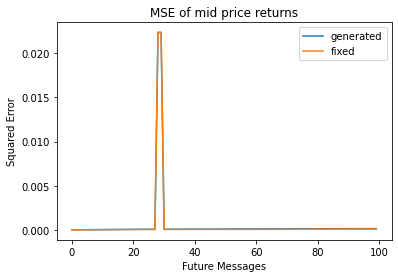

In [39]:
plt.plot(
    jnp.sqrt(mid_ret_errs.mean(axis=0)),
    label='generated'
)
plt.plot(
    jnp.sqrt(mid_ret_errs_const.mean(axis=0)),
    label='fixed'
)
plt.legend()
plt.title('MSE of mid price returns')
plt.xlabel('Future Messages')
plt.ylabel('Squared Error')

Text(0, 0.5, 'Squared Error')

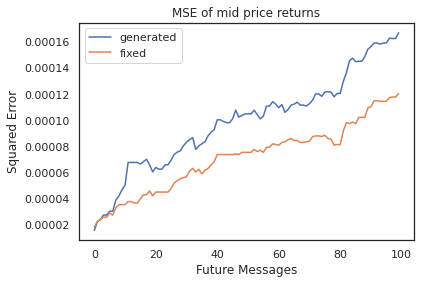

In [106]:
plt.plot(
    jnp.sqrt(mid_ret_errs.mean(axis=0)),
    label='generated'
)
plt.plot(
    jnp.sqrt(mid_ret_errs_const.mean(axis=0)),
    label='fixed'
)
plt.legend()
plt.title('MSE of mid price returns')
plt.xlabel('Future Messages')
plt.ylabel('Squared Error')

In [ ]:
#%lprun -f book_loss book_loss(l2_book_states[0], b_seq_pv_eval[0, 1:])

Timer unit: 1e-09 s

Total time: 0.0552547 s
File: /tmp/ipykernel_2612316/1534013801.py
Function: book_loss at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           def book_loss(
     3                                                   gen_l2: jax.Array,
     4                                                   act_l2: jax.Array,
     5                                               ):
     6                                           
     7         1       1022.0   1022.0      0.0      def union_price_repr(a, b):
     8                                                   # append prices from b not already contained in a to a
     9                                                   p_not_in_a = jnp.setdiff1d(
    10                                                       b[:, 0],
    11                                                       a[:, 0],
    12                                                       #assume_unique=Tr

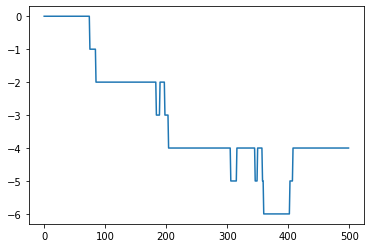

In [65]:
# price drift in sequence
plt.plot(onp.cumsum(b_seq[:, 0]))

In [107]:
def plot_l2_book(i_book, ax, xlim=None, ylim=None):
    i, book = i_book
    book = onp.array(book.reshape((-1, 2)))
    book[::2, 1] = book[::2, 1] * -1
    book = book[book[:, 0] != -1]

    ax.clear()
    plt.title("L2 Book: " + ticker + " - " + data_date + " - " + start_time_dt.strftime("%H:%M:%S"))
    plt.xlabel("Volume")
    plt.ylabel("Price")
    # option 2, remove all lines and collections
    # for artist in ax.lines + ax.collections:
    #     artist.remove()
    time_text = ax.text(
        0.05, 0.95, '#state: ' + str(i),
        horizontalalignment='left',verticalalignment='top',
        transform=ax.transAxes
    )
    
    bars = ax.barh(book[:, 0], book[:, 1], height=90, color='b')
    
    #xlim = ax.get_xlim()
    #x_abs_max = onp.max(onp.abs(xlim))
    #ax.set_xlim(-x_abs_max, x_abs_max)

    ylim = ax.get_ylim()
    p_mid = (book[0, 0] + book[1, 0]) / 2
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is None:
        y_half_range = onp.max((ylim[1] - p_mid, p_mid - ylim[0]))
        ax.set_ylim(p_mid + y_half_range, p_mid - y_half_range)
    else:
        ax.set_ylim(ylim)

    return bars

<BarContainer object of 19 artists>

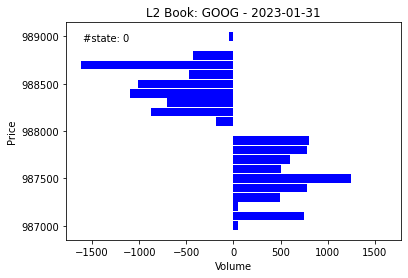

In [91]:
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)
plt.title("L2 Book: " + ticker + " - " + data_date)
plt.xlabel("Volume")
plt.ylabel("Price")
max_vol = int(1.1 * onp.max(l2_book_states.reshape(l2_book_states.shape[0], -1, 2)[:, :, 1]))
xlim = (-max_vol, max_vol)

plot_l2_book((0, l2_book_states[1]), ax, xlim=xlim)

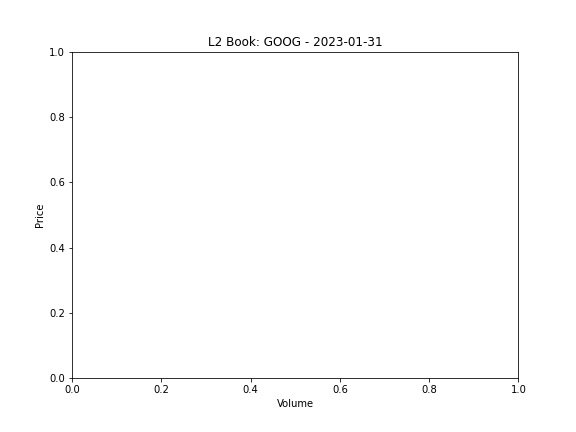

In [115]:
%matplotlib ipympl

import matplotlib.animation

max_vol = int(1.1 * onp.max(l2_book_states.reshape(l2_book_states.shape[0], -1, 2)[:, :, 1]))
xlim = (-max_vol, max_vol)

fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot(111)
plt.title("L2 Book: " + ticker + " - " + data_date)
plt.xlabel("Volume")
plt.ylabel("Price")

ani = matplotlib.animation.FuncAnimation(
    fig,
    lambda b: plot_l2_book(b, ax, xlim=xlim),
    frames=list(enumerate(l2_book_states)),
    interval=200,
    repeat_delay=1000,
    #blit=True,
)
#plt.tight_layout()
plt.show()
ani.save(
    '../tmp/animation.webp',
    writer='imagemagick',
    fps=5,
    savefig_kwargs=dict(facecolor='#EAEAF2')
)

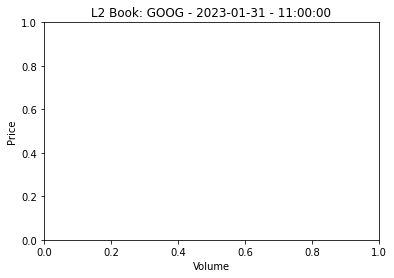

In [130]:
#pause
ani.event_source.stop()

#unpause
#ani.event_source.start()

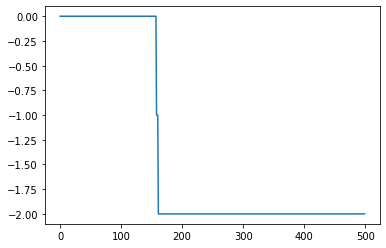

In [150]:
%matplotlib inline

# price drift in sequence
plt.plot(onp.cumsum(b_seq[:, 0]))

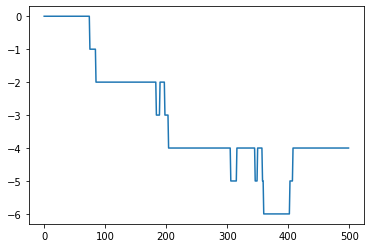

In [120]:
%matplotlib inline

# inspect movement of best bid price for sequence including
# generated flow at the end

# price drift in sequence
plt.plot(onp.cumsum(b_seq[:, 0]))

In [156]:
%matplotlib inline

l = Message_Tokenizer.MSG_LEN
decod_gen_msgs = tok.decode(m_seq.reshape((-1,l))[-100:], v)
decod_gen_msgs = pd.DataFrame(decod_gen_msgs, columns=Message_Tokenizer.FIELDS)
decod_gen_msgs

,time,event_type,size,price,direction,time_new,event_type_new,size_new,price_new,direction_new
0,5.399342e+12,1.0,100.0,-1.0,1.0,NaN,NaN,NaN,NaN,NaN
1,5.399282e+12,1.0,100.0,-2.0,1.0,5.399342e+12,3.0,100.0,-1.0,1.0
2,5.399350e+12,1.0,100.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN
3,5.399282e+12,1.0,100.0,-2.0,1.0,5.399350e+12,3.0,100.0,-1.0,1.0
4,5.399257e+12,1.0,200.0,-1.0,1.0,5.399350e+12,2.0,100.0,-1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
95,5.399304e+12,1.0,600.0,4.0,0.0,5.399347e+12,2.0,51.0,6.0,0.0
96,5.399299e+12,1.0,100.0,-1.0,1.0,NaN,NaN,NaN,NaN,NaN
97,5.399334e+12,1.0,50.0,-7.0,1.0,5.399298e+12,3.0,50.0,-7.0,1.0
98,5.398295e+12,1.0,306.0,-8.0,1.0,NaN,NaN,NaN,NaN,NaN


In [160]:
%matplotlib inline
decod_gen_msgs['size'].value_counts().sort_index()

3.0       1
21.0      1
25.0      1
50.0     13
51.0     10
61.0      3
100.0    53
200.0    11
300.0     2
306.0     3
600.0     2
Name: size, dtype: int64

<AxesSubplot:>

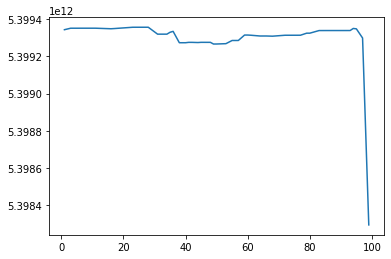

In [161]:
%matplotlib inline

# arriving mod times should be monotonically increasing...
decod_gen_msgs.dropna(subset=['time_new']).time_new.plot()

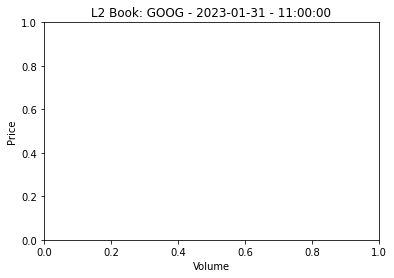

In [162]:
# new orders
new_orders = decod_gen_msgs.loc[decod_gen_msgs.time_new.isna()]

0     5.399342e+12
2     5.399350e+12
12    5.399350e+12
13    5.399346e+12
14    5.399346e+12
15    5.399348e+12
18    5.399372e+12
19    5.399354e+12
20    5.399355e+12
21    5.399355e+12
22    5.399355e+12
29    5.399313e+12
30    5.399317e+12
33    5.399318e+12
37    5.399256e+12
43    5.399273e+12
46    5.399271e+12
51    5.399265e+12
52    5.399265e+12
54    5.399256e+12
58    5.401286e+12
62    5.399311e+12
63    5.399308e+12
65    5.399309e+12
67    5.399309e+12
69    5.399308e+12
70    5.399312e+12
71    5.399312e+12
78    5.399324e+12
81    5.399338e+12
82    5.399338e+12
86    5.399338e+12
92    5.399338e+12
96    5.399299e+12
98    5.398295e+12
Name: time, dtype: float64

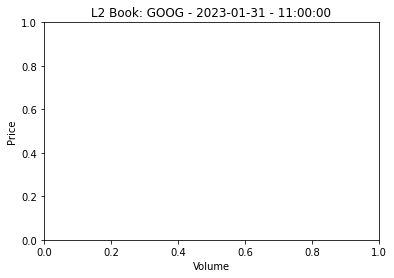

In [163]:
new_orders.time

<AxesSubplot:title={'center':'L2 Book: GOOG - 2023-01-31 - 11:00:00'}, xlabel='Volume', ylabel='Price'>

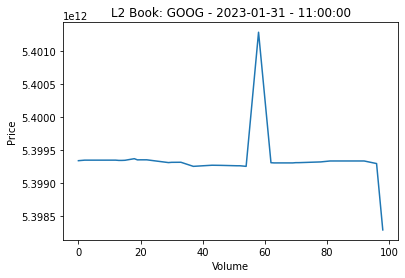

In [164]:
# error: should be monotonically increasing
new_orders.time.plot()

In [74]:
new_orders.event_type.value_counts()

1.0    65
Name: event_type, dtype: int64

In [75]:
# only order modifications
modif_orders = decod_gen_msgs.dropna()

In [76]:
modif_orders.event_type_new.value_counts()

3.0    22
2.0     9
4.0     2
Name: event_type_new, dtype: int64

### Model Validation (optional)

In [ ]:
dataset_obj = LOBSTER(
    'lobster',
    #data_dir='/nfs/home/peern/LOBS5/data/',
    data_dir='/nfs/home/peern/LOBS5/data/new_enc/',
    mask_fn=LOBSTER_Dataset.causal_mask,
    use_book_data=True,
    book_transform=True,
    msg_seq_len=500,
    n_cache_files=100,
)
dataset_obj.setup()

In [ ]:
test_loader = make_data_loader(
    dataset_obj.dataset_test,
    dataset_obj,
    seed=args.jax_seed,
    batch_size=args.bsz,
    drop_last=True,
    shuffle=False,
    num_workers=0
)

In [26]:
rng = jax.random.PRNGKey(42)
tok = Message_Tokenizer()

all_pred_toks = []
all_labels = []

losses = []
accuracy = []
ranks = []
valid_mass = []
valid_mass_n5 = []
valid_pred = []
losses_baseline = []

VALID_MATRIX = valh.syntax_validation_matrix()

for batch_idx, batch in enumerate(tqdm(test_loader)):
    
    # PREPARE BATCH
    inputs, labels, integration_timesteps = prep_batch(batch, seq_len, n_classes, num_devices=1)
    # INFERENCE STEP
    loss, acc, pred = eval_step(
        inputs, labels, integration_timesteps, par_state, model.apply, args.batchnorm)

    loss = loss.squeeze(axis=0)
    acc = acc.squeeze(axis=0)
    pred = pred.squeeze(axis=0)
    
    # STORE RESULTS
    pred_toks = pred.argmax(axis=-1)
    all_labels += labels.tolist()
    all_pred_toks += pred_toks.tolist()
    
    # STATS
    losses.append(cross_entropy_loss(pred, labels))
    accuracy.append(compute_accuracy(pred, labels))
    
    # where does the correct label rank in the predicted distribution?
    ranks.append(valh.pred_rank(pred, labels))
    # how much of the predicted distribution is valid?
    masked_fields = valh.get_masked_fields(batch[0])
    valid_mass.append(valh.valid_prediction_mass(pred, masked_fields))
    valid_mass_n5.append(valh.valid_prediction_mass(pred, masked_fields, top_n=5))

    # check if argmax prediction is valid token for masked fields
    valid_pred.append(valh.is_tok_valid(pred_toks, masked_fields, v))

    # benchmark: uniform prediction over syntactically valid tokens
    pos = valh.get_masked_idx(batch[0])[..., -1]
    baseline_distr = VALID_MATRIX[pos] / VALID_MATRIX[pos].sum(axis=-1, keepdims=True)
    losses_baseline.append(cross_entropy_loss(jnp.log(
            jnp.where(baseline_distr==0, 1e-10, baseline_distr)
        ), labels)
    )

all_labels = jnp.array(all_labels)
all_pred_toks = jnp.array(all_pred_toks)
losses = jnp.array(losses)
accuracy = jnp.array(accuracy)
ranks = jnp.array(ranks)
valid_mass = jnp.array(valid_mass)
valid_mass_n5 = jnp.array(valid_mass_n5)
valid_pred = jnp.array(valid_pred)
losses_baseline = jnp.array(losses_baseline)

NameError: name 'test_loader' is not defined

In [ ]:
print('mean loss', losses.mean())
print('mean accuracy', accuracy.mean())
print('mean rank', ranks.mean())
print('median rank', onp.median(ranks))
print('mean valid mass', valid_mass.mean())
print('mean valid mass (top 5)', valid_mass_n5.mean())
print('mean valid prediction', valid_pred.mean())
print('mean baseline loss (uniform over valid syntax)', losses_baseline.mean())

mean loss 1.4749558
mean accuracy 0.688901
mean rank 72.28813
median rank 0.0
mean valid mass 0.971541
mean valid mass (top 5) 0.9579046
mean valid prediction 0.98988515
mean baseline loss (uniform over valid syntax) 5.2721515


In [ ]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as onp
import pandas as pd


precision, recall, fscore, support = precision_recall_fscore_support(
    all_labels.astype(int),
    all_pred_toks,
    labels=range(len(v)),
    zero_division=0,
    average=None
)

'''
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))
'''

"\nprint('precision: {}'.format(precision))\nprint('recall: {}'.format(recall))\nprint('fscore: {}'.format(fscore))\nprint('support: {}'.format(support))\n"

In [ ]:
field_dec = onp.array([(field, dec) for tok, (field, dec) in sorted(v.DECODING_GLOBAL.items())])

scores_df = pd.DataFrame({
    'field': field_dec[:, 0],
    'decoded': field_dec[:, 1],
    'precision': precision,
    'recall': recall,
    'fscore': fscore,
    'support': support,
})
#scores_df

In [ ]:
# left to right causal prediction:

scores_df.loc[scores_df.support > 0].groupby('field').agg(
    precision=('precision', 'mean'),
    recall=('recall', 'mean'),
    fscore=('fscore', 'mean'),
    support=('support', 'sum'),
)

,precision,recall,fscore,support
field,,,,
direction,0.624236,0.632841,0.626838,436
event_type,0.393960,0.399946,0.396617,465
generic,1.000000,0.998603,0.999301,716
price,0.557158,0.452684,0.477146,676
size,0.213366,0.152106,0.170773,680
time,0.011118,0.037804,0.016177,685
